In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.metrics import f1_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler

In [40]:
def clip_outliers(df, factor=1.5):
    df_clipped = df.copy()
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clipped[col] = np.clip(df[col], lower, upper)
    return df_clipped


In [81]:
df = pd.read_csv("winequality-red.csv", sep=';')
df.head()


X = df.drop("quality", axis=1)
y = df["quality"]

In [82]:
#feature selection
corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.9)]
X_reduced = X.drop(columns=to_drop)

In [83]:
#scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_reduced)

In [ ]:
#decrease class number
y_binned = pd.cut(
    y,
    bins=[2, 4, 6, 8],
    labels=[0, 1, 2]
)

In [84]:
#splitting (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify = y)

In [48]:
#ANN
ann_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ann", MLPClassifier(
        max_iter=10000,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=42
    ))
])

#hyperparameter tuning with randomized search
param_dist = {
    "ann__hidden_layer_sizes": [ (32,), (64,), (64, 32), (128, ), (128, 32), (128, 64), (128, 64, 32)],
    "ann__activation": ["relu", "tanh", "logistic"],
    "ann__alpha": loguniform(1e-4, 1e-2),
    "ann__learning_rate_init": loguniform(1e-4, 1e-2)
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [49]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,                  
    scoring="f1_weighted",
    cv=cv,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print("Best hyperparameters:")
print(random_search.best_params_)

print("Best CV F1-score:")
print(random_search.best_score_)

Best hyperparameters:
{'ann__activation': 'relu', 'ann__alpha': np.float64(0.002878805718308925), 'ann__hidden_layer_sizes': (128, 64), 'ann__learning_rate_init': np.float64(0.0059487468132197715)}
Best CV F1-score:
0.6380781606799468


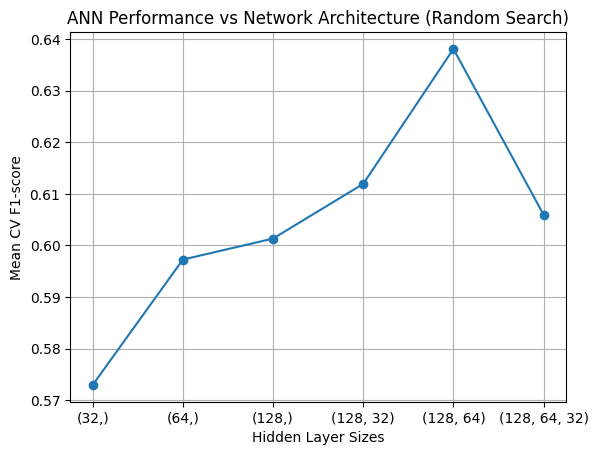

In [51]:
#visualize hypertuning
results = pd.DataFrame(random_search.cv_results_)

#performance vs hidden layer
layer_scores = (
    results.groupby("param_ann__hidden_layer_sizes")["mean_test_score"]
    .mean()
)

layer_scores.plot(marker="o")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Mean CV F1-score")
plt.title("ANN Performance vs Network Architecture (Random Search)")
plt.grid(True)
plt.show()

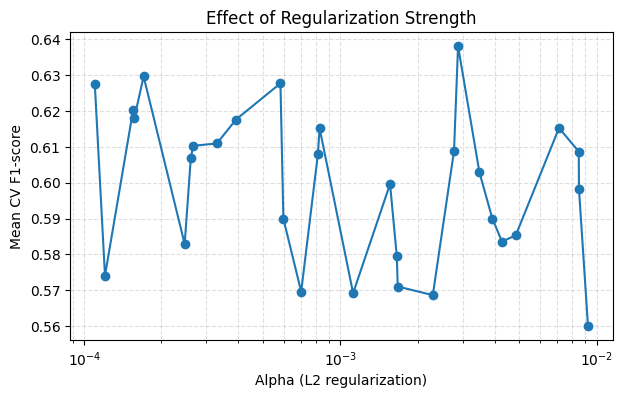

In [52]:
#performance vs regularization
alpha_summary = (
    results
    .groupby("param_ann__alpha")["mean_test_score"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(7, 4))
plt.plot(alpha_summary.index, alpha_summary.values, marker="o")
plt.xscale("log")
plt.xlabel("Alpha (L2 regularization)")
plt.ylabel("Mean CV F1-score")
plt.title("Effect of Regularization Strength")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()

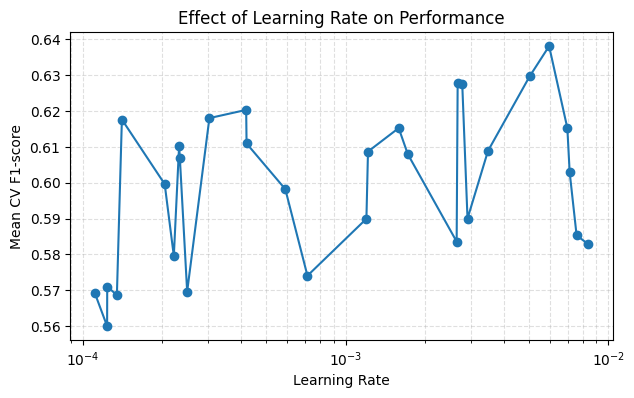

In [53]:
#performance vs learning rate
lr_summary = (
    results
    .groupby("param_ann__learning_rate_init")["mean_test_score"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(7, 4))
plt.plot(lr_summary.index, lr_summary.values, marker="o")
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Mean CV F1-score")
plt.title("Effect of Learning Rate on Performance")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()


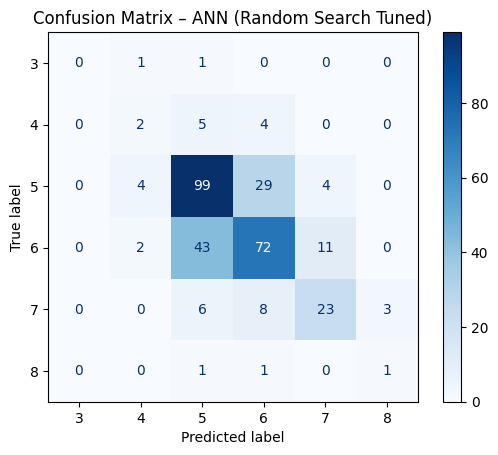

Test F1-score (weighted): 0.6104633068040988
Test accuracy: 0.615625


In [54]:
#confusion matrix, F1 score, and accuracy
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=sorted(y_test.unique())
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – ANN (Random Search Tuned)")
plt.show()

test_f1 = f1_score(y_test, y_pred, average="weighted")
print("Test F1-score (weighted):", test_f1)

test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_accuracy)

In [55]:
#Naive Bayes
pipeline_nb = Pipeline([
    ("clip", FunctionTransformer(clip_outliers)),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("nb", GaussianNB(var_smoothing=1e-9))
])
cv_nb = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [56]:
#hypertuning
param_dist = {
    "nb__var_smoothing": np.logspace(-10, -8, 50)
}

random_search_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=30,
    scoring="f1_weighted",
    cv=cv_nb,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

random_search_nb.fit(X_train, y_train)
best_nb = random_search_nb.best_estimator_

print("Best var_smoothing:", random_search_nb.best_params_)
print("Best CV F1-score:", random_search_nb.best_score_)

Best var_smoothing: {'nb__var_smoothing': np.float64(6.866488450042998e-09)}
Best CV F1-score: 0.5649504189908481


In [57]:
#evaluation
y_pred_nb = best_nb.predict(X_test)

test_f1 = f1_score(y_test, y_pred_nb, average="weighted")
test_accuracy = accuracy_score(y_test, y_pred_nb)

print("Test F1-score (weighted):", test_f1)
print("Test accuracy:", test_accuracy)

Test F1-score (weighted): 0.5511229502006182
Test accuracy: 0.55625


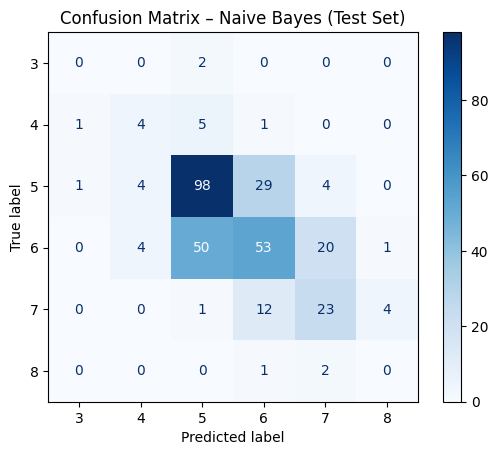

In [58]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=sorted(y.unique())
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Naive Bayes (Test Set)")
plt.show()

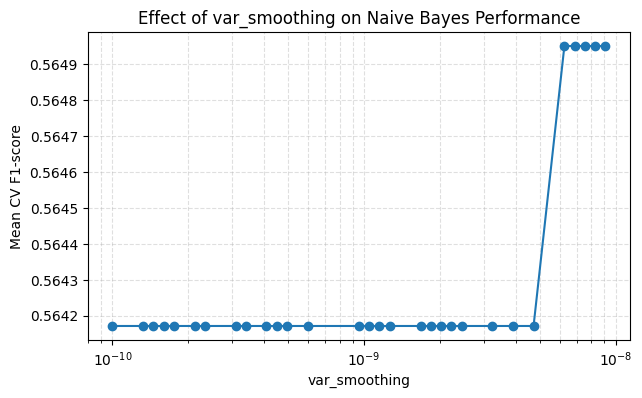

In [59]:
results_nb = pd.DataFrame(random_search_nb.cv_results_)

summary = (
    results_nb
    .groupby("param_nb__var_smoothing")["mean_test_score"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(7, 4))
plt.plot(summary.index, summary.values, marker="o")
plt.xscale("log")
plt.xlabel("var_smoothing")
plt.ylabel("Mean CV F1-score")
plt.title("Effect of var_smoothing on Naive Bayes Performance")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()

In [85]:
#KNN
pipeline_k = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

cv_k = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [86]:
from scipy.stats import randint

param_dist_k = {
    "knn__n_neighbors": randint(3, 31),   # odd k avoids ties
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan", "minkowski"],
    "knn__p": [1, 2]  # relevant for Minkowski
}

random_search_k = RandomizedSearchCV(
    estimator=pipeline_k,
    param_distributions=param_dist_k,
    n_iter=40,
    scoring="f1_weighted",
    cv=cv_k,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

random_search_k.fit(X_train, y_train)
print("Best hyperparameters:")
print(random_search_k.best_params_)

print("Best CV F1-score:")
print(random_search_k.best_score_)

Best hyperparameters:
{'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__p': 1, 'knn__weights': 'distance'}
Best CV F1-score:
0.6509054269486777


Test F1-score (weighted): 0.6401890827024278
Test accuracy: 0.653125


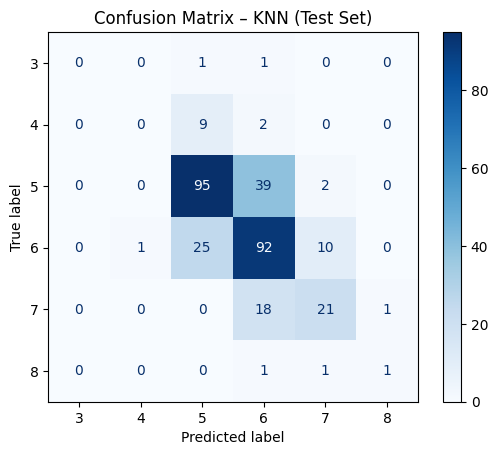

In [87]:
#evaluation
best_knn = random_search_k.best_estimator_

y_test_pred = best_knn.predict(X_test)

test_f1 = f1_score(y_test, y_test_pred, average="weighted")
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test F1-score (weighted):", test_f1)
print("Test accuracy:", test_accuracy)

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=sorted(y.unique())
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – KNN (Test Set)")
plt.show()

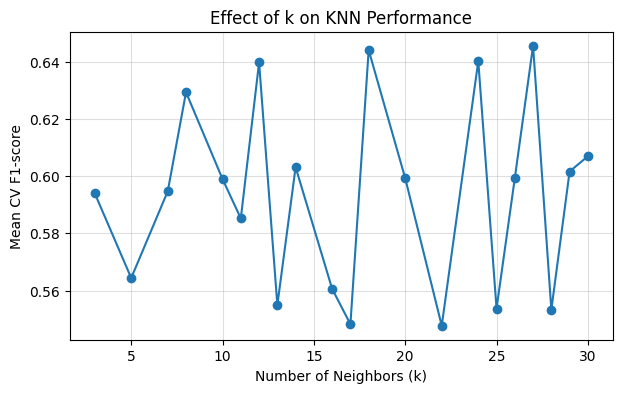

In [88]:
results_k = pd.DataFrame(random_search_k.cv_results_)

k_summary = (
    results_k
    .groupby("param_knn__n_neighbors")["mean_test_score"]
    .mean()
    .sort_index()
)

plt.figure(figsize=(7, 4))
plt.plot(k_summary.index, k_summary.values, marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean CV F1-score")
plt.title("Effect of k on KNN Performance")
plt.grid(True, alpha=0.4)
plt.show()